# Uvodni deo rada

## Tema, predmet i svrha rada
**Tema:** Ekstrakcija informacija iz neuređenog teksta primenom Velikih Jezičkih Modela (LLM) i upotreba tih informacija za naprednu analizu podataka.
**Predmet:** Recenzije restorana (Google Maps stil) koje sadrže tekstualne opise i numeričke ocene.
**Svrha:** Cilj je automatski izvući strukturirane podatke (kao što su sentiment prema specifičnim aspektima: hrana, usluga, atmosfera) iz teksta recenzija kako bi se obogatio osnovni skup podataka. Tako obogaćen skup podataka omogućava detaljniju analizu i kreiranje preciznijih prediktivnih modela.

## Podaci
Korišćeni podaci predstavljaju skup recenzija restorana. Svaki red u datasetu sadrži ime restorana, tekst recenzije i prateću ocenu (rating). Podaci su realni primeri korisničkih iskustava i sadrže netrivijalne tekstualne opise koji su pogodni za NLP obradu.
Dataset je preuzet sa javno dostupnog repozitorijuma prilagođenog za potrebe ovog projekta. Sadrži tekstualnu varijablu `text` iz koje vršimo ekstrakciju. (https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews)

## Metodologija
U ovom radu koristimo sledeći metodološki pristup:
1.  **Priprema podataka (Data Cleaning & EDA):** Učitavanje podataka, analiza distribucije dužine teksta i ocena, i filtriranje irelevantnih (prekratkih) recenzija.
2.  **Ekstrakcija informacija (Information Extraction):** 
    -   **Model:** Koristimo `Llama-3.1-8b-instant` model serviran preko `Groq` API-a zbog njegove brzine i efikasnosti.
    -   **Pristup:** Definisana je stroga šema (`ReviewsIESchema`) koristeći `Pydantic` biblioteku koja obavezuje model da vrati strukturirani JSON output. Ekstrahujemo pozitivne i negativne komentare za 6 ključnih aspekata (hrana, usluga, atmosfera, cena, čistoća, lokacija), kao i opšti sentiment i glavni problem.
    -   **Prompt Engineering:** Koristimo `system` prompt koji modelu daje ulogu eksperta za ekstrakciju informacija sa jasnim pravilima (npr. ne halucinirati, koristiti kratke fraze).
3.  **Obogaćivanje dataseta:** Rezultati ekstrakcije se spajaju sa originalnim podacima.
4.  **Prediktivna analiza:** Na osnovu ekstrahovanih informacija kreiramo nove numeričke varijable (npr. broj pozitivnih komentara o hrani) i koristimo ih kao ulaz za ML model (Random Forest) kako bismo predvideli ocenu korisnika ili sentiment. 
    -   **Evaluacija:** Koristićemo Accuracy i Classification Report za evaluaciju uspešnosti modela.

# 0) Loading API key

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())  
assert os.getenv("GROQ_API_KEY"), "Nema GROQ_API_KEY. Proveri .env."
RAND_STATE = 1

# 1) Loading dataset 

In [2]:
import pandas as pd
data = pd.read_csv('data/reviews.csv')

# 2) EDA + Data Cleaning

In [3]:
data.head(10)

,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu
5,Haci'nin Yeri - Yigit Lokantasi,Arda Karaca,Generally good.,dataset/indoor_atmosphere/hacinin_yeri_arda_ka...,4,indoor_atmosphere
6,Haci'nin Yeri - Yigit Lokantasi,İrem Eren,What you see is 125 TL in total. It's a pretty...,dataset/taste/hacinin_yeri_irem_eren.png,5,taste
7,Haci'nin Yeri - Yigit Lokantasi,Nadia Salim,Delicious food at rock bottom prices. Friendly...,dataset/taste/hacinin_yeri_nadia_salim.png,5,taste
8,Haci'nin Yeri - Yigit Lokantasi,Mehmet Eser,"Every time I go, I still experience the amazem...",dataset/outdoor_atmosphere/hacinin_yeri_mehmet...,5,outdoor_atmosphere
9,Haci'nin Yeri - Yigit Lokantasi,Celal Ozer,The most f/p of all businesses I've seen.,dataset/indoor_atmosphere/hacinin_yeri_celal_o...,5,indoor_atmosphere


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.7+ KB


Drop: author_name (ne koristimo identitet autora), photo (radimo tekst-only), rating_category (redundantno jer koristim rating kao target).

In [5]:
data.drop(columns=['author_name','photo','rating_category'], inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   business_name  1100 non-null   object
 1   text           1100 non-null   object
 2   rating         1100 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.9+ KB


In [7]:
data.isna().sum()

business_name    0
text             0
rating           0
dtype: int64

In [8]:
data['TextLength'] = data.text.apply(len)

In [9]:
data.head()

,business_name,text,rating,TextLength
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday...,5,680
1,Haci'nin Yeri - Yigit Lokantasi,During my holiday in Marmaris we ate here to f...,4,914
2,Haci'nin Yeri - Yigit Lokantasi,Prices are very affordable. The menu in the ph...,3,173
3,Haci'nin Yeri - Yigit Lokantasi,Turkey's cheapest artisan restaurant and its f...,5,63
4,Haci'nin Yeri - Yigit Lokantasi,I don't know what you will look for in terms o...,3,161


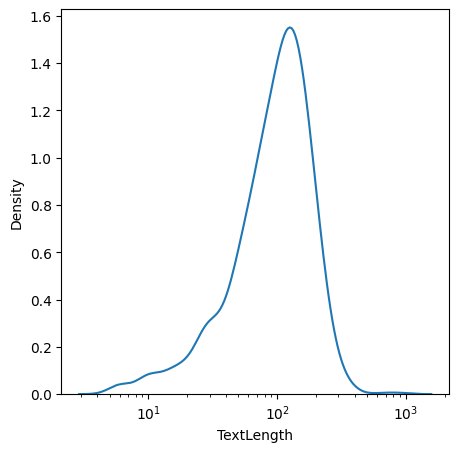

In [10]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
sb.kdeplot(data=data, x='TextLength', log_scale=True)
plt.show()

### Interpretacija Distribucije (KDE Plot)
Grafik iznad prikazuje log-normalnu raspodelu dužine recenzija. Većina recenzija je kraća (oko 100 karaktera), ali postoji dug rep distribucije sa veoma opširnim opisima.

- **Zaključak:** Ova raspodela opravdava uklanjanje ekstremno kratkih tekstova (donjih 10%) u narednom koraku, jer verovatno ne sadrže dovoljno informacija za kvalitetnu ekstrakciju, dok su duži tekstovi bogatiji podacima.

- Uklanjaje malih tekstova

In [11]:
import numpy as np
tenth_perc = np.percentile(data.TextLength.values, 10)
data_sub = data.loc[data.TextLength > tenth_perc,].copy()
data_sub.reset_index(drop=True, inplace=True)
data_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   business_name  985 non-null    object
 1   text           985 non-null    object
 2   rating         985 non-null    int64 
 3   TextLength     985 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 30.9+ KB


- Provera par tekstova

In [12]:
for text in data_sub.text.sample(15, random_state=RAND_STATE):
    print(text)
    print("#######################################")

Ambience is very nice but they don't let you work at the outside tables; that is a negative point.
#######################################
The pickles that came after you placed your order were very nice. Tantuni is not bad; you can try it. But I would say it's a little oily.
#######################################
After waiting for about 20 minutes; we were able to eat Classic Ayvalık Toast. It was delicious and crunchy.
#######################################
Excellent appetizers; great atmosphere; acceptable prices.
#######################################
We had dinner in a very stylish place with a beautiful view by the sea. The flavors were perfect.
#######################################
Unique in Alsancak Kordon.. Good food; especially chicken wrap is awesome.
#######################################
A very nice place; five stars as the location. If it is the flavor you are looking for; you may not find the exact flavor that you want.
#######################################
A caf

In [13]:
data_sub.describe()

,rating,TextLength
count,985.000000,985.000000
mean,3.887310,121.414213
std,1.232393,65.281652
min,1.000000,33.000000
25%,3.000000,75.000000
50%,4.000000,112.000000
75%,5.000000,153.000000
max,5.000000,914.000000


In [14]:
def sentiment(rating:float) -> str:
    if float(rating) < 3: return "negative"
    return "positive" if float(rating) > 3 else "neutral"
data_sub['rating_to_sentiment'] = data_sub.rating.apply(sentiment)
data_sub.rating_to_sentiment.value_counts()

rating_to_sentiment
positive    686
neutral     155
negative    144
Name: count, dtype: int64

### Komentar o Balansu Klasa (Sentiment Distribution)
Analizom distribucije `rating_to_sentiment` vidimo značajan disbalans: pozitivne ocene (4 i 5) dominiraju nad neutralnim i negativnim.

- **Uticaj:** Ovo moze uticati na pristrasnost (bias) klasifikacionog modela ka pozitivnoj klasi.

# 3) Defining IE Schema for GoogleMaps Restaurant Reviews

In [15]:
from pydantic import BaseModel, Field
from typing import Optional, List
from enum import Enum

class Sentiment(str, Enum):
    negative = "negative"
    neutral = "neutral"
    positive = "positive"

class ReviewsIESchema(BaseModel):
    """Structured information extracted from a Google Maps restaurant review text."""

    # Food
    food_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about food (taste, quality, portions, menu, dishes). FOOD only.",
        examples=[["delicious pizza", "fresh ingredients", "great portions"]]
    )
    food_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about food (taste, quality, portions, menu, dishes). FOOD only.",
        examples=[["overcooked pasta", "bland taste", "small portion"]]
    )

    # Staff 
    service_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about service/staff (friendliness, speed, professionalism).",
        examples=[["friendly staff", "quick service"]]
    )
    service_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about service/staff (rude staff, slow service, mistakes).",
        examples=[["rude waiter", "slow service", "order was wrong"]]
    )

    # Atmosphere 
    atmosphere_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about atmosphere/ambience (music, vibe, interior, comfort).",
        examples=[["cozy atmosphere","good atmosphere", "nice music", "beautiful interior"]]
    )
    atmosphere_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about atmosphere/ambience (too loud, crowded, uncomfortable).",
        examples=[["too noisy", "crowded", "uncomfortable seating"]]
    )
    
    #  Price / Value 
    price_value_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about price/value (good value, affordable, worth it).",
        examples=[["good value for money", "fair prices"]]
    )
    price_value_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about price/value overpriced, not worth it).",
        examples=[["overpriced", "not worth the money"]]
    )

    # Cleanliness
    cleanliness_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about cleanliness (clean tables, clean restroom, hygiene).",
        examples=[["very clean place", "clean restroom"]]
    )
    cleanliness_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about cleanliness (dirty tables, poor hygiene, dirty restroom).",
        examples=[["dirty table", "unclean restroom"]]
    )

    # Location / Access / Parking
    location_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about location/access/parking.",
        examples=[["great location", "easy parking"]]
    )
    location_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about location/access/parking.",
        examples=[["hard to find", "no parking"]]
    )

    # Wait time / Queue
    wait_time_positives: Optional[List[str]] = Field(
        default=[],
        description="Positive comments about waiting time (served quickly, no queue).",
        examples=[["served quickly", "no wait"]]
    )
    wait_time_negatives: Optional[List[str]] = Field(
        default=[],
        description="Negative comments about waiting time (long wait, slow kitchen).",
        examples=[["long wait", "took 40 minutes"]]
    )

    # Extras (optional but useful)
    mentioned_dishes_or_drinks: Optional[List[str]] = Field(
        default=[],
        description="Specific dishes/drinks explicitly mentioned in the review (names as written).",
        examples=[["burger", "ramen", "latte"]]
    )

    main_issue: Optional[str] = Field(
    default=None,
    description="Main complaint/problem summarized in a short phrase; null if not applicable."
    )

    sentiment: Sentiment = Field(
        default = Sentiment.neutral,
        description="The sentiment expressed in the review. It can be one of the following: positive, negative, or neutral",
        examples=[Sentiment.positive]
    )


# 4) Defining the IE chain (prompt + schema + LLM): implementing an information extraction pipeline from text

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from prompts import IE_SYSTEM_MSG

ie_system_msg = IE_SYSTEM_MSG
model_name = "llama-3.1-8b-instant"
llm = ChatGroq(model=model_name, temperature=0.0 ,max_tokens= 800)
google_maps_restaurant_ie_llm = llm.with_structured_output(schema=ReviewsIESchema)
google_maps_restaurant_ie_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", ie_system_msg),
        ("human", "Extract details about a restaurant review, given below:\n{text}"),
    ]
)

restaurant_ie_chain = google_maps_restaurant_ie_prompt_template | google_maps_restaurant_ie_llm

# 5) Pipeline testing for extraction on examples

In [17]:
import textwrap
from time import sleep
restaurant_reviews_sample = data_sub["text"].sample(3,random_state= RAND_STATE).to_list()

for text in restaurant_reviews_sample:
    response = restaurant_ie_chain.invoke({"text": text})
    print(textwrap.fill(text, width=100))
    print("\nExtracted info:")
    print(f"Overall sentiment: {response.sentiment}")

    print(f"Food positives: {response.food_positives}")
    print(f"Food negatives: {response.food_negatives}")

    print(f"Service positives: {response.service_positives}")
    print(f"Service negatives: {response.service_negatives}")

    print(f"Atmosphere positives: {response.atmosphere_positives}")
    print(f"Atmosphere negatives: {response.atmosphere_negatives}")

    print(f"Price/Value positives: {response.price_value_positives}")
    print(f"Price/Value negatives: {response.price_value_negatives}")

    print(f"Cleanliness positives: {response.cleanliness_positives}")
    print(f"Cleanliness negatives: {response.cleanliness_negatives}")

    print(f"Location positives: {response.location_positives}")
    print(f"Location negatives: {response.location_negatives}")

    print(f"Wait time positives: {response.wait_time_positives}")
    print(f"Wait time negatives: {response.wait_time_negatives}")
    
    print(f"Mentions (dishes/drinks): {response.mentioned_dishes_or_drinks}")
    print(f"Main issue: {response.main_issue}")
    
    print("#" * 100)

Ambience is very nice but they don't let you work at the outside tables; that is a negative point.

Extracted info:
Overall sentiment: Sentiment.negative
Food positives: []
Food negatives: []
Service positives: []
Service negatives: ["don't let you work at the outside tables"]
Atmosphere positives: ['very nice']
Atmosphere negatives: ["don't let you work at the outside tables"]
Price/Value positives: []
Price/Value negatives: []
Cleanliness positives: []
Cleanliness negatives: []
Location positives: []
Location negatives: []
Wait time positives: []
Wait time negatives: []
Mentions (dishes/drinks): []
Main issue: don't let you work at the outside tables
####################################################################################################
The pickles that came after you placed your order were very nice. Tantuni is not bad; you can try
it. But I would say it's a little oily.

Extracted info:
Overall sentiment: Sentiment.neutral
Food positives: ['nice pickles']
Food negative

# 6) Sample tagging (balanced) + rate limit + merge back to DF


Komentar: Zbog preovladavanja pozitivnog sentimenta (4 i 5) nad negativnim (1 i 2) i neutralnim (3) zajedno, uzimamo jednak uzorak iz svakog sentimenta, kako bi se resili potencijalne pristrasnosti modela.

In [18]:
sample_size = 20

positive_sample = data_sub.loc[data_sub.rating_to_sentiment=='positive'].sample(sample_size, random_state=RAND_STATE)
negative_sample = data_sub.loc[data_sub.rating_to_sentiment=='negative'].sample(sample_size, random_state=RAND_STATE)
neutral_sample = data_sub.loc[data_sub.rating_to_sentiment=='neutral'].sample(sample_size, random_state=RAND_STATE)
review_sample = pd.concat([positive_sample, negative_sample, neutral_sample], axis=0, ignore_index=True)
review_sample = review_sample.sample(frac=1, random_state=RAND_STATE,ignore_index=True) # shuffle all rows
review_sample.head()

,business_name,text,rating,TextLength,rating_to_sentiment
0,Kasikla Restaurant,We ate special ravioli; classic ravioli; yagla...,2,129,negative
1,KFC,A very small hamburger. I can say that there a...,3,194,neutral
2,Nazar Cafe,I went with my friends; their milk desserts we...,5,59,positive
3,Pecko Firin Atakum,there are 10 waiters standing; the tables are ...,3,109,neutral
4,Berdan Doner,Service was bad. I think a few treats should b...,3,54,neutral


In [19]:
import pandas as pd

def llm_tagging(review: str):
    try:
        return restaurant_ie_chain.invoke({"text": review})
    except Exception as e:
        print(f"Error when processing review:\n{review}\n{e}")
        return None
    finally:
        sleep(3)  # rate limit

tagging_results = []

for i, review in enumerate(review_sample["text"].tolist()):
    if i % 10 == 0:
        print(f"Processing {i+1}. review")

    res = llm_tagging(review)

    tagging_results.append({
        "llm_sentiment": (res.sentiment.value if res else None),

        "food_positives": (res.food_positives if res else []),
        "food_negatives": (res.food_negatives if res else []),

        "service_positives": (res.service_positives if res else []),
        "service_negatives": (res.service_negatives if res else []),

        "atmosphere_positives": (res.atmosphere_positives if res else []),
        "atmosphere_negatives": (res.atmosphere_negatives if res else []),

        "price_value_positives": (res.price_value_positives if res else []),
        "price_value_negatives": (res.price_value_negatives if res else []),

        "cleanliness_positives": (res.cleanliness_positives if res else []),
        "cleanliness_negatives": (res.cleanliness_negatives if res else []),

        "location_positives": (res.location_positives if res else []),
        "location_negatives": (res.location_negatives if res else []),

        "wait_time_positives": (res.wait_time_positives if res else []),
        "wait_time_negatives": (res.wait_time_negatives if res else []),

        "mentioned_dishes_or_drinks": (res.mentioned_dishes_or_drinks if res else []),
        "main_issue": (res.main_issue if res else None),
    })

tagging_res_df = pd.DataFrame(tagging_results)

Processing 1. review
Processing 11. review
Error when processing review:
Slagethi all nero was excellent. Beef ribs were always tender enough. Cheek, on the other hand; has preserved its taste even though its collection is a little small. If deterioration was to come; the services were passed and the environment was much expected.
Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=ReviewsIESchema> {"atmosphere_positives": ["cozy atmosphere"], "food_positives": ["excellent Slagethi all nero", "tender beef ribs", "preserved taste of Cheek"], "food_negatives": ["small portion of Cheek"], "service_positives": ["good service"], "sentiment": "positive", "main_issue": null}'}}
Processing 21. review
Error when processing review:
I can't say anything negative about the place, the ambiance; the staff; the richness of t

In [20]:
tagging_res_df.head(20)

,llm_sentiment,food_positives,food_negatives,service_positives,service_negatives,atmosphere_positives,atmosphere_negatives,price_value_positives,price_value_negatives,cleanliness_positives,cleanliness_negatives,location_positives,location_negatives,wait_time_positives,wait_time_negatives,mentioned_dishes_or_drinks,main_issue
0,neutral,[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],None
1,negative,[],"[small hamburger, not delicious, not worth the...",[],[],[],"[very busy, small]",[],"[overpriced, not worth the money]",[],[],[],[hard to find a place to sit],[],[],[hamburger],overpriced and small portions
2,positive,[very good milk desserts],[],[friendly staff],[],[cozy atmosphere],[],[],[],[],[],[],[],[],[],[milk desserts],None
3,negative,[delicious],[],[],[slow service],[empty tables],[],[],[],[],[],[],[],[],[slow service],[],slow service
4,negative,[],[],[],[bad service],[],[],[],[],[],[],[],[],[],[],[],bad service
5,neutral,[not a problem],"[lacking salt, affects taste]",[],[],[breakfast],[],[],[],[],[],[],[],[],[],[flakes],None
6,negative,[],[very bad food],[],[],[beautiful view],[],[],[],[],[],[beautiful view],[],[],[],[],very bad food
7,negative,[],[small portions],[],[],[],[],[],[high prices],[],[],[],[],[],[],[],None
8,negative,[],[sorbet desserts are not satisfactory],[],[],[],[humid environment],[],[],[],[],[],[],[],[],[sorbet],air conditioners not working
9,negative,[],[],[],[],[cozy atmosphere],[uncomfortable atmosphere],[],[],[],[],[],[],[],[],[],uncomfortable atmosphere


# 7) Analysis of obtained data (extracted features)

In [21]:
tagged_review_sample = pd.concat([review_sample, tagging_res_df], axis=1)
tagged_review_sample.head()

,business_name,text,rating,TextLength,rating_to_sentiment,llm_sentiment,food_positives,food_negatives,service_positives,service_negatives,...,price_value_positives,price_value_negatives,cleanliness_positives,cleanliness_negatives,location_positives,location_negatives,wait_time_positives,wait_time_negatives,mentioned_dishes_or_drinks,main_issue
0,Kasikla Restaurant,We ate special ravioli; classic ravioli; yagla...,2,129,negative,neutral,[],[],[],[],...,[],[],[],[],[],[],[],[],[],None
1,KFC,A very small hamburger. I can say that there a...,3,194,neutral,negative,[],"[small hamburger, not delicious, not worth the...",[],[],...,[],"[overpriced, not worth the money]",[],[],[],[hard to find a place to sit],[],[],[hamburger],overpriced and small portions
2,Nazar Cafe,I went with my friends; their milk desserts we...,5,59,positive,positive,[very good milk desserts],[],[friendly staff],[],...,[],[],[],[],[],[],[],[],[milk desserts],None
3,Pecko Firin Atakum,there are 10 waiters standing; the tables are ...,3,109,neutral,negative,[delicious],[],[],[slow service],...,[],[],[],[],[],[],[],[slow service],[],slow service
4,Berdan Doner,Service was bad. I think a few treats should b...,3,54,neutral,negative,[],[],[],[bad service],...,[],[],[],[],[],[],[],[],[],bad service


In [22]:
tagged_review_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   business_name               60 non-null     object
 1   text                        60 non-null     object
 2   rating                      60 non-null     int64 
 3   TextLength                  60 non-null     int64 
 4   rating_to_sentiment         60 non-null     object
 5   llm_sentiment               52 non-null     object
 6   food_positives              60 non-null     object
 7   food_negatives              60 non-null     object
 8   service_positives           60 non-null     object
 9   service_negatives           60 non-null     object
 10  atmosphere_positives        60 non-null     object
 11  atmosphere_negatives        60 non-null     object
 12  price_value_positives       60 non-null     object
 13  price_value_negatives       60 non-null     object
 

# 8) Validation: Comparison of Rating and LLM Sentiment

In [23]:
from statistics import mean

def label_match(row):
    human_lbl = row['rating_to_sentiment']
    llm_lbl = "other" if not row['llm_sentiment'] else row['llm_sentiment']
    return human_lbl == llm_lbl

sentiment_match = tagged_review_sample.apply(label_match, axis=1)
print(f"Number of matched labels: {sum(sentiment_match)}")
print(f"Proportion of matched labels: {mean(sentiment_match):.4f}")

Number of matched labels: 30
Proportion of matched labels: 0.5000


In [24]:
tagged_review_sample['sentiment_matched'] = sentiment_match
tagged_review_sample.loc[~tagged_review_sample.sentiment_matched, ['text', 'rating_to_sentiment', 'llm_sentiment']]

,text,rating_to_sentiment,llm_sentiment
0,We ate special ravioli; classic ravioli; yagla...,negative,neutral
1,A very small hamburger. I can say that there a...,neutral,negative
3,there are 10 waiters standing; the tables are ...,neutral,negative
4,Service was bad. I think a few treats should b...,neutral,negative
8,Unfortunately; the sorbet desserts are not sat...,neutral,negative
11,Portion is enough; taste is average; but unfor...,neutral,negative
12,Slagethi all nero was excellent. Beef ribs wer...,neutral,None
14,I ate boyoz for the first time. For me; I gues...,negative,neutral
16,It does not bad. The best part was if the pric...,negative,neutral
18,The service is good; the employees are concern...,neutral,negative


In [25]:
tagged_review_sample.llm_sentiment.value_counts()

llm_sentiment
negative    25
positive    15
neutral     12
Name: count, dtype: int64

Note: Nas model ima pristranost ka negativnom sentimentu.

# 9) Predictive Analysis (Prediktivna Analiza)
Koristimo ekstrahovane feature-e (broj pozitivnih/negativnih komentara po aspektima) za predikciju stvarnog sentimenta (Rating category).

In [26]:
# Feature engineering
# Pretvaramo liste aspekata u numericke vrednosti
aspects = ['food', 'service', 'atmosphere', 'price_value', 'cleanliness', 'location', 'wait_time']

#Kopiranja u novi dataset za dalju analizu
analysis_df = tagged_review_sample.copy()
for aspect in aspects:
    # Broj pozitivnih komentara za aspekt
    analysis_df[f'{aspect}_pos_count'] = analysis_df[f'{aspect}_positives'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    # Broj negativnih komentara za aspekt
    analysis_df[f'{aspect}_neg_count'] = analysis_df[f'{aspect}_negatives'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Prikaz novih kolona
analysis_df[[f'{aspect}_pos_count' for aspect in aspects] + [f'{aspect}_neg_count' for aspect in aspects]].head()

,food_pos_count,service_pos_count,atmosphere_pos_count,price_value_pos_count,cleanliness_pos_count,location_pos_count,wait_time_pos_count,food_neg_count,service_neg_count,atmosphere_neg_count,price_value_neg_count,cleanliness_neg_count,location_neg_count,wait_time_neg_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,3,0,2,2,0,1,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Model training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Definisemo features i target
feature_cols = [f'{aspect}_pos_count' for aspect in aspects] + [f'{aspect}_neg_count' for aspect in aspects]
X = analysis_df[feature_cols]
y = analysis_df['rating_to_sentiment'] # Target je sentiment izveden iz ocene

# Split na train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RAND_STATE,stratify=y) # Stratifikujemo po y da bi se raspodele klasa ocuvale

**9.1)** Applying CV for to ensure best parameters

- Za klasifikator sam izabrao Random Forest jer je pouzdan “baseline” model za klasifikaciju i dobro radi kada imamo više ulaznih karakteristika (npr. TF-IDF/BoW ili ocene + dodatne feature-e), bez potrebe za komplikovanim podešavanjem.Robustan na šum i outliere zbog vise stabala.
- Omogućava uvid u važnost karakteristika (feature importance), pa možemo lakše objasniti šta modelu najviše doprinosi (npr. određene reči, ocena, dužina recenzije…).
- Kao dodatni praktičan razlog: na malom uzorku je često stabilniji od nekih linearnih modela bez pažljivog tuninga, i daje brzu procenu performansi za dalju iteraciju.

In [102]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_STATE)

# Model + grid
rf = RandomForestClassifier(random_state=RAND_STATE)
param_grid = {
    "n_estimators": [4, 6, 8, 10, 12, 14, 16, 18]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="accuracy",  
    cv=cv,
    n_jobs=-1,
    refit=True
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'n_estimators': 12}
Best CV score: 0.5199999999999999


In [107]:
clf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], random_state=RAND_STATE)
clf.fit(X_train, y_train)

# Predikcija
y_pred = clf.predict(X_test)

# Evaluacija
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred,zero_division=0))

Accuracy: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

    negative       0.67      0.50      0.57         4
     neutral       0.60      0.75      0.67         4
    positive       0.75      0.75      0.75         4

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.66        12
weighted avg       0.67      0.67      0.66        12



- Accuracy – za 67% sentimenata izvedenih na osnovu ocena smo tačno predvideli da li ce biti negativni/neutralni/pozitvni
- Precision – od svih negativnih,neutralnih,pozitvnih sentimenata za koje smo predvideli da ce biti takvi, respektivno 67%,60%,75% zaista i jesu takvi
- Recall – od svih negativnih,neutralnih,pozitvnih koji zaista jesu takvi, mi smo tačno predvideli respektivno 50%,75%,75% njih
- F1 score – mera koja balansira preciznost i odziv, i u našem slučaju iznosi za negativne,neutralne,pozitivne respektivno 57%, 67%, 75%. Može se reći da naš model solidno balansira između sposobnosti da prepozna većinu negativnih,neutralnih,pozitivnih sentimenata koji zaista i jesu takvi i toga da ne označava previše sentimenata nepravilno u neke druge kao sentimente kada oni to zapravo nisu.
- MacroAvg racuna prosek za svaku od metrika.Kod nas je accuracy 67%, recall 67% i f1-score 66%

# 10) Feature Importance 

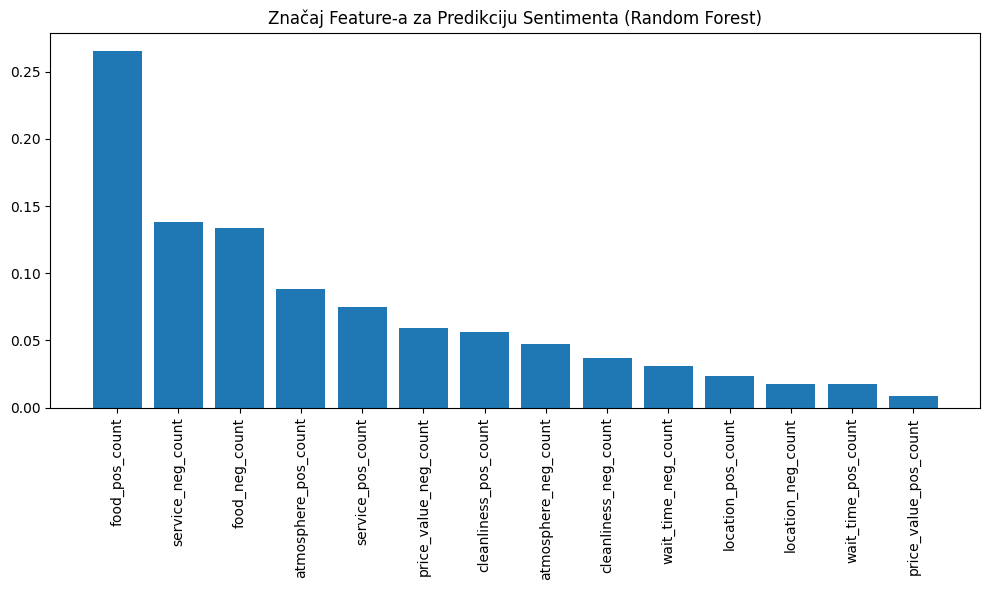

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Feature Importance Plot
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Značaj Feature-a za Predikciju Sentimenta (Random Forest)")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

**INTERPRETACIJA FEATURE IMPORTANCE PLOT-A**
- Bar chart iznad prikazuje koji su 'feature-i' (pozitivni/negativni komentari o hrani, usluzi, atmosferi, itd..) bili najvažniji modelu za donošenje odluke."
- Kod nas najvise na klasifikaciju utice: food_pos_count
- Vrlo znacajan uticaj imaju i: food_neg_count,service_neg_count,atmosphere_pos_count
- Pa zatim sve ostale: price_value_count,cleanliness_post_count...

# 11) Confusion Matrix

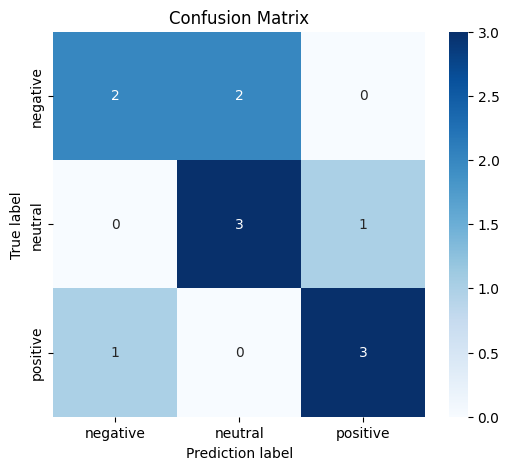

In [109]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Prediction label')
plt.ylabel('True label')
plt.show()

**INTERPRETACIJA REZULTATA MATRICE KONFUZIJE**
- Matrica konfuzije prikazuje na X osi predvidjene vrednosti sentimenata izvedenih na osnovu ocene a Y predstavlja stvarne vrednosti sentimenata
- Glavna dijagonala predstavlja sva tacna predvidjana naseg modela
- Sva polja van sporedne dijagonale predstavljaju netacna predvidjanja
- Model najbolje prepoznaje neutralne i pozitivne klase.

**Napomena:** Rezultati predikcije su indikativni jer su trenirani na veoma malom uzorku (60 primera) zbog ograničenja API poziva u ovom demou. Za realnu primenu, potrebno je procesirati ceo dataset.